# EXERCISE 4

The data in `ESE06_ex4.csv` report life-time measurements for electric circuits. Design an X-bar and S control chart.

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('ESE06_ex4.csv')

# Inspect the dataset
data.head()

Perform some data snooping first. 

In [ ]:
# Make a scatter plot of all the columns against the index
plt.plot(data['x1'], linestyle='none', marker='o', label = 'x1')
plt.plot(data['x2'], linestyle='none', marker='o', label = 'x2')
plt.plot(data['x3'], linestyle='none', marker='o', label = 'x3')
plt.plot(data['x4'], linestyle='none', marker='o', label = 'x4')
plt.plot(data['x5'], linestyle='none', marker='o', label = 'x5')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Some outliers are present. 

In [ ]:
# Stack the data into a single column
data_stack = data.stack()

# Plot a histogram of the data_stack
data_stack.hist()
plt.show()

In [ ]:
# We can use the Shapiro-Wilk test
_, p_value_SW = stats.shapiro(data_stack)
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_stack, dist="norm", plot=plt)
plt.show()

The data are skewed and not normal. Let's try to transform them.

> Let's transform the data to make it more normal using the Box-Cox transformation.
>
> Remember the Box-Cox transformation is defined as:
> $$x_{BC,i} = \left\{ \begin{array}{ll} \frac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \ln x_i & \text{if } \lambda = 0 \end{array} \right.$$

In [ ]:
# Box-Cox transformation and return the transformed data
[data_BC, lmbda] = stats.boxcox(data_stack)

print('Lambda = %.3f' % lmbda)

# Plot a histogram of the transformed data
plt.hist(data_BC)
plt.show()

By default, the Box-Cox function used Lambda = -0.037. A more interpretable (and very close to optimum) value is Lambda = 0.

In [ ]:
# Use lambda = 0 for Box-Cox transformation and return the transformed data
data_BC = stats.boxcox(data_stack, lmbda=0)

# Plot a histogram of the transformed data
plt.hist(data_BC)
plt.show()

> Now the data seem to follow a normal distribution. Let's verify this by testing the normality.

In [ ]:
# We can use the Shapiro-Wilk test
_, p_value_SW = stats.shapiro(data_BC)
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_BC, dist="norm", plot=plt)
plt.show()

> Normality is verified. We can now use the X-bar and R chart on the transformed data.

In [ ]:
# First we need to unstack the data
data_BC_unstack = data_BC.reshape(data.shape)
# and convert it to a DataFrame
data_BC_unstack = pd.DataFrame(data_BC_unstack, columns = data.columns)

# Print out the transformed data
data_BC_unstack.head()

In [ ]:
# X-bar and R charts
data_BC_XR = qda.ControlCharts.XbarR(data_BC_unstack)

The process is in control. Let's try now with the X-bar and S chart.

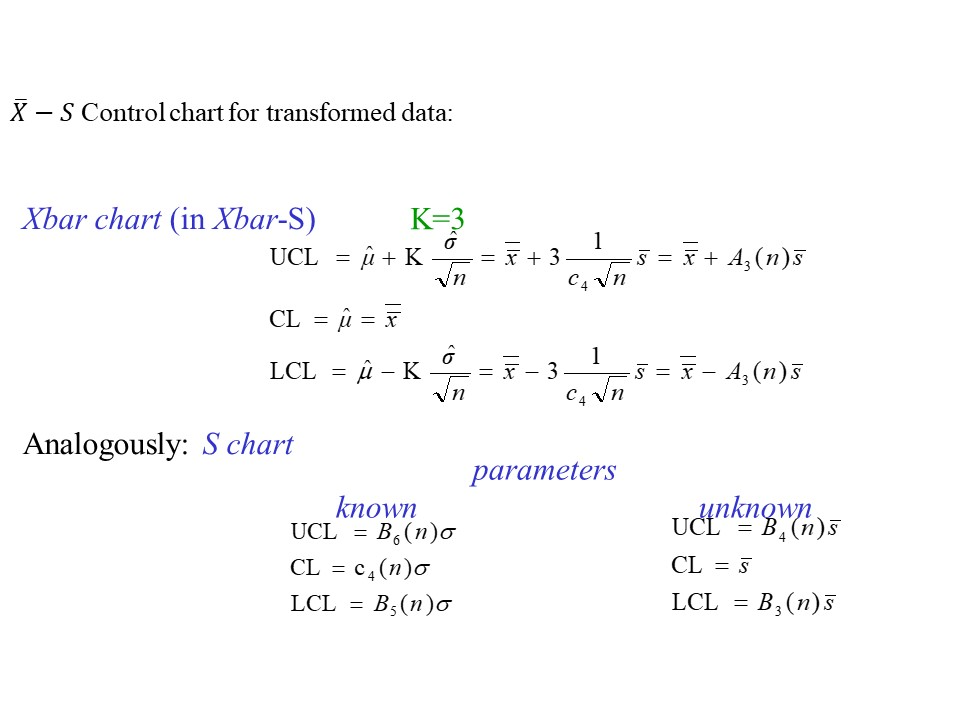
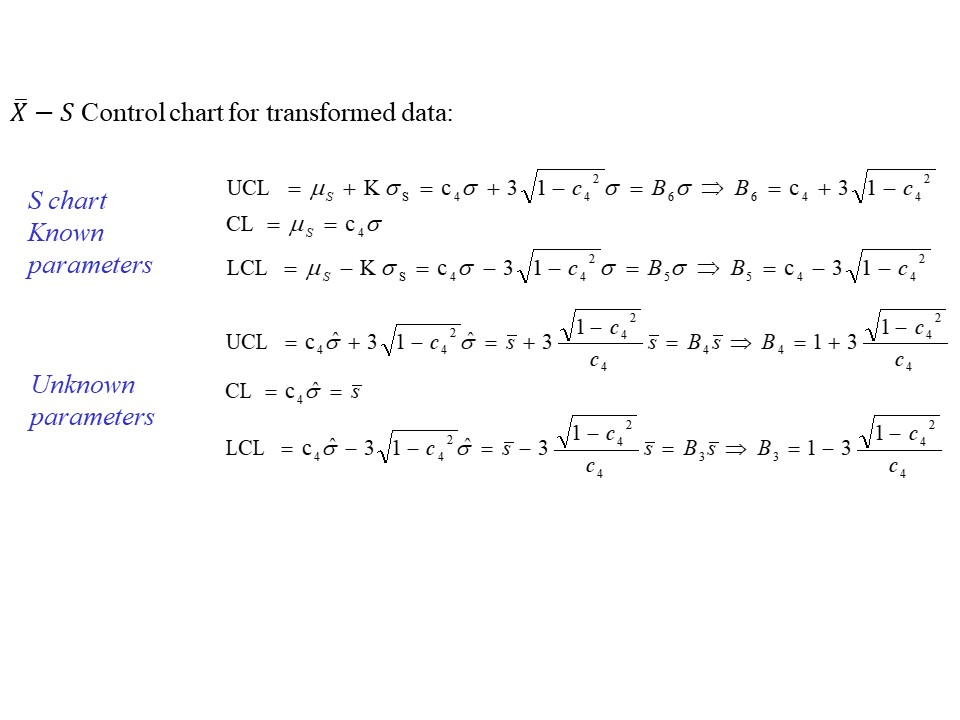

> Let's compute the mean and the range for each sample. 
> 
> *Note: we need to apply the mean and std functions to each row of the data frame.*

In [ ]:
# Make a copy of the data
data_XS = data_BC_unstack.copy()
# Add a column with the mean of the rows
data_XS['sample_mean'] = data_BC_unstack.mean(axis=1)
# Add a column with the range of the rows
data_XS['sample_std'] = data_BC_unstack.std(axis=1)

# Inspect the dataset
data_XS.head()

> Now compute the grand mean and the mean of the ranges.

In [ ]:
Xbar_mean = data_XS['sample_mean'].mean()
S_mean = data_XS['sample_std'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % S_mean)

In [ ]:
n = 5
K = 3
A3 = K * 1 / (qda.constants.getc4(n) * np.sqrt(n))
B3 = np.maximum(1 - K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n)), 0)
B4 = 1 + K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n))

# Now we can compute the CL, UCL and LCL for Xbar and S
data_XS['Xbar_CL'] = Xbar_mean
data_XS['Xbar_UCL'] = Xbar_mean + A3 * S_mean
data_XS['Xbar_LCL'] = Xbar_mean - A3 * S_mean

data_XS['S_CL'] = S_mean
data_XS['S_UCL'] = B4 * S_mean
data_XS['S_LCL'] = B3 * S_mean

# Inspect the dataset
data_XS.head()

> Add two columns to store the violations of the control limits.

In [ ]:
data_XS['Xbar_TEST1'] = np.where((data_XS['sample_mean'] > data_XS['Xbar_UCL']) | 
                (data_XS['sample_mean'] < data_XS['Xbar_LCL']), data_XS['sample_mean'], np.nan)
data_XS['S_TEST1'] = np.where((data_XS['sample_std'] > data_XS['S_UCL']) | 
                (data_XS['sample_std'] < data_XS['S_LCL']), data_XS['sample_std'], np.nan)

> Now plot the limits and the data in the charts.

In [ ]:
# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XS['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['Xbar_UCL'], color='r')
plt.plot(data_XS['Xbar_CL'], color='g')
plt.plot(data_XS['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [ ]:
# Plot the S chart
plt.title('S chart')
plt.plot(data_XS['sample_std'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['S_UCL'], color='r')
plt.plot(data_XS['S_CL'], color='g')
plt.plot(data_XS['S_LCL'], color='r')
plt.ylabel('Sample S')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['S_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['S_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['S_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['S_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['S_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In alternative, you can use the `XbarS` function from the `qda` package.

In [ ]:
# X-bar and S charts
data_BC_XS = qda.ControlCharts.XbarS(data_BC_unstack)